Implementacao OpenCV

In [ ]:
from __future__ import print_function
import cv2
import matplotlib.pyplot as plt
import argparse

def detectAndDisplay(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.equalizeHist(frame_gray)
    #-- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray)
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        frame = cv2.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = frame_gray[y:y+h,x:x+w]
        #-- In each face, detect eyes
        eyes = eyes_cascade.detectMultiScale(faceROI)
        for (x2,y2,w2,h2) in eyes:
            eye_center = (x + x2 + w2//2, y + y2 + h2//2)
            radius = int(round((w2 + h2)*0.25))
            frame = cv2.circle(frame, eye_center, radius, (255, 0, 0 ), 4)
    cv2.imshow('Capture - Face detection', frame)

parser = argparse.ArgumentParser(description='Code for Cascade Classifier tutorial.')
parser.add_argument('--face_cascade', help='Path to face cascade.', default='data/haarcascades/haarcascade_frontalface_alt.xml')
parser.add_argument('--eyes_cascade', help='Path to eyes cascade.', default='data/haarcascades/haarcascade_eye_tree_eyeglasses.xml')
parser.add_argument('--camera', help='Camera divide number.', type=int, default=0)
args = parser.parse_args()

face_cascade_name = args.face_cascade
eyes_cascade_name = args.eyes_cascade

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')


if face_cascade.empty():
    print('--(!)Error loading face cascade')
    exit(0)
if eyes_cascade.empty():
    print('--(!)Error loading eyes cascade')
    exit(0)


Ativar camera

In [20]:
camera_device = args.camera
cap = cv2.VideoCapture(camera_device)
if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)

while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        cap.release()
        cv2.destroyAllWindows()
        break

    detectAndDisplay(frame)

    if cv2.waitKey(10) == 27:
        cap.release()
        cv2.destroyAllWindows()
        break
    

In [21]:
print(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\cv2\data\haarcascade_frontalface_alt.xml


Implementacao DNN

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import argparse
%matplotlib inline
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

Imagens para demonstracao

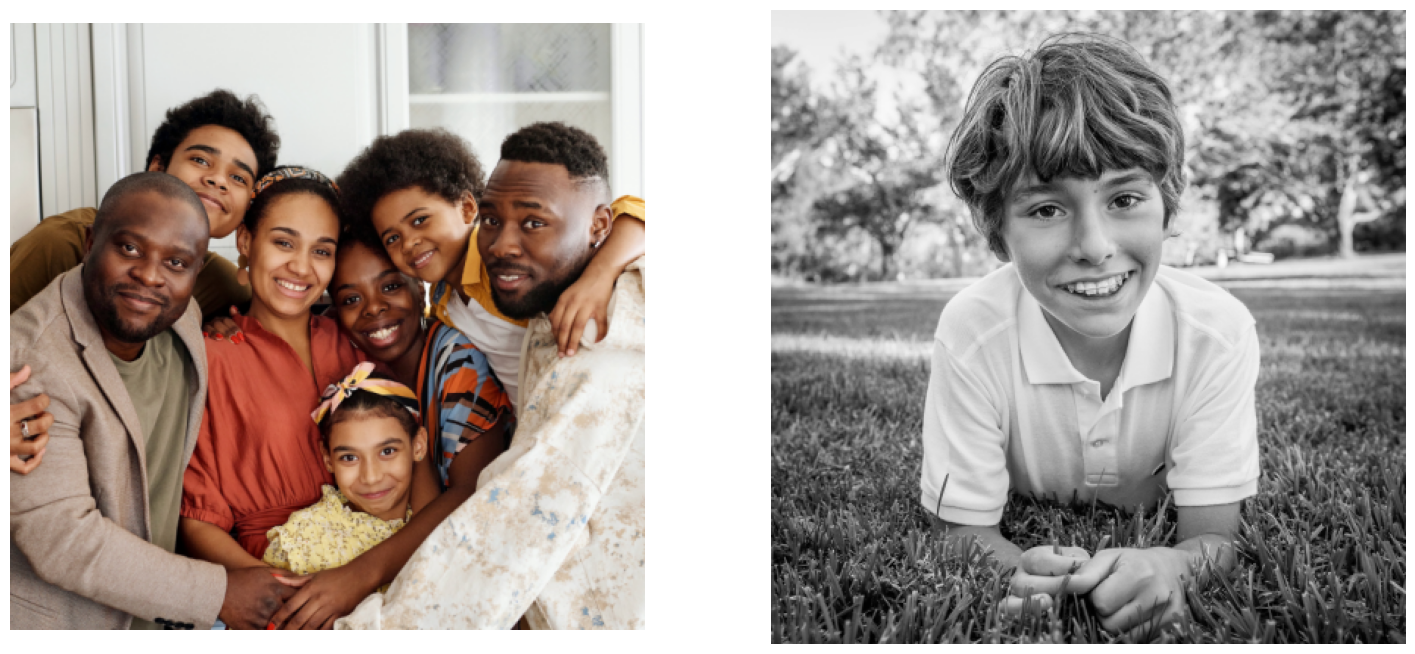

In [23]:
img1 = cv2.imread('Images/family.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('Images/boy.jpg', cv2.IMREAD_COLOR)

fig = plt.figure(figsize=(18,10))

plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1])
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img2[:,:,::-1])

Carrega a rede neural como objeto

In [24]:
modelFile = 'Model/res10_300x300_ssd_iter_140000.caffemodel'
configFile = 'Model/deploy.prototxt'

# Read the model and create a network object.
net = cv2.dnn.readNetFromCaffe(prototxt=configFile, caffeModel=modelFile)

Salva parametros usado para a rede neural como variaveis

In [25]:
# Model parameters used to train model.
mean = [104, 117, 123]
scale = 1.0
in_width = 300
in_height = 300

Seleciona opcoes para deteccao e demonstracao

In [31]:
# Set the detection threshold for face detections.
detection_threshold = 0.5

# Annotation settings.
font_style = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.2
font_thickness = 1

Funcao de deteccao

In [27]:
# Function for rectangular blur with dnn
def detect(frame, net = net, scale = scale, mean = mean, in_width = in_width, in_height = in_height):
    h = frame.shape[0]
    w = frame.shape[1]
   # Convert the image into a blob format.
    blob = cv2.dnn.blobFromImage(frame, scalefactor=scale, 
                                 size=(in_width, in_height), mean=mean, swapRB=False, crop=False)
    # Pass the blob to the DNN model.
    net.setInput(blob)
    # Retrieve detections from the DNN model.
    detections = net.forward()

    # Process each detection.
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype('int')

            # Annotate the video frame with the detection results.
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = 'Confidence: %.4f' % confidence
            label_size, base_line = cv2.getTextSize(label, font_style, font_scale, font_thickness)
            cv2.rectangle(frame, (x1, y1 - label_size[1]), (x1 + label_size[0], y1 + base_line), 
                          (255, 255, 255), cv2.FILLED)
            cv2.putText(frame, label, (x1, y1), font_style, font_scale, (0, 0, 0))
    return frame


Imagens com deteccao feita

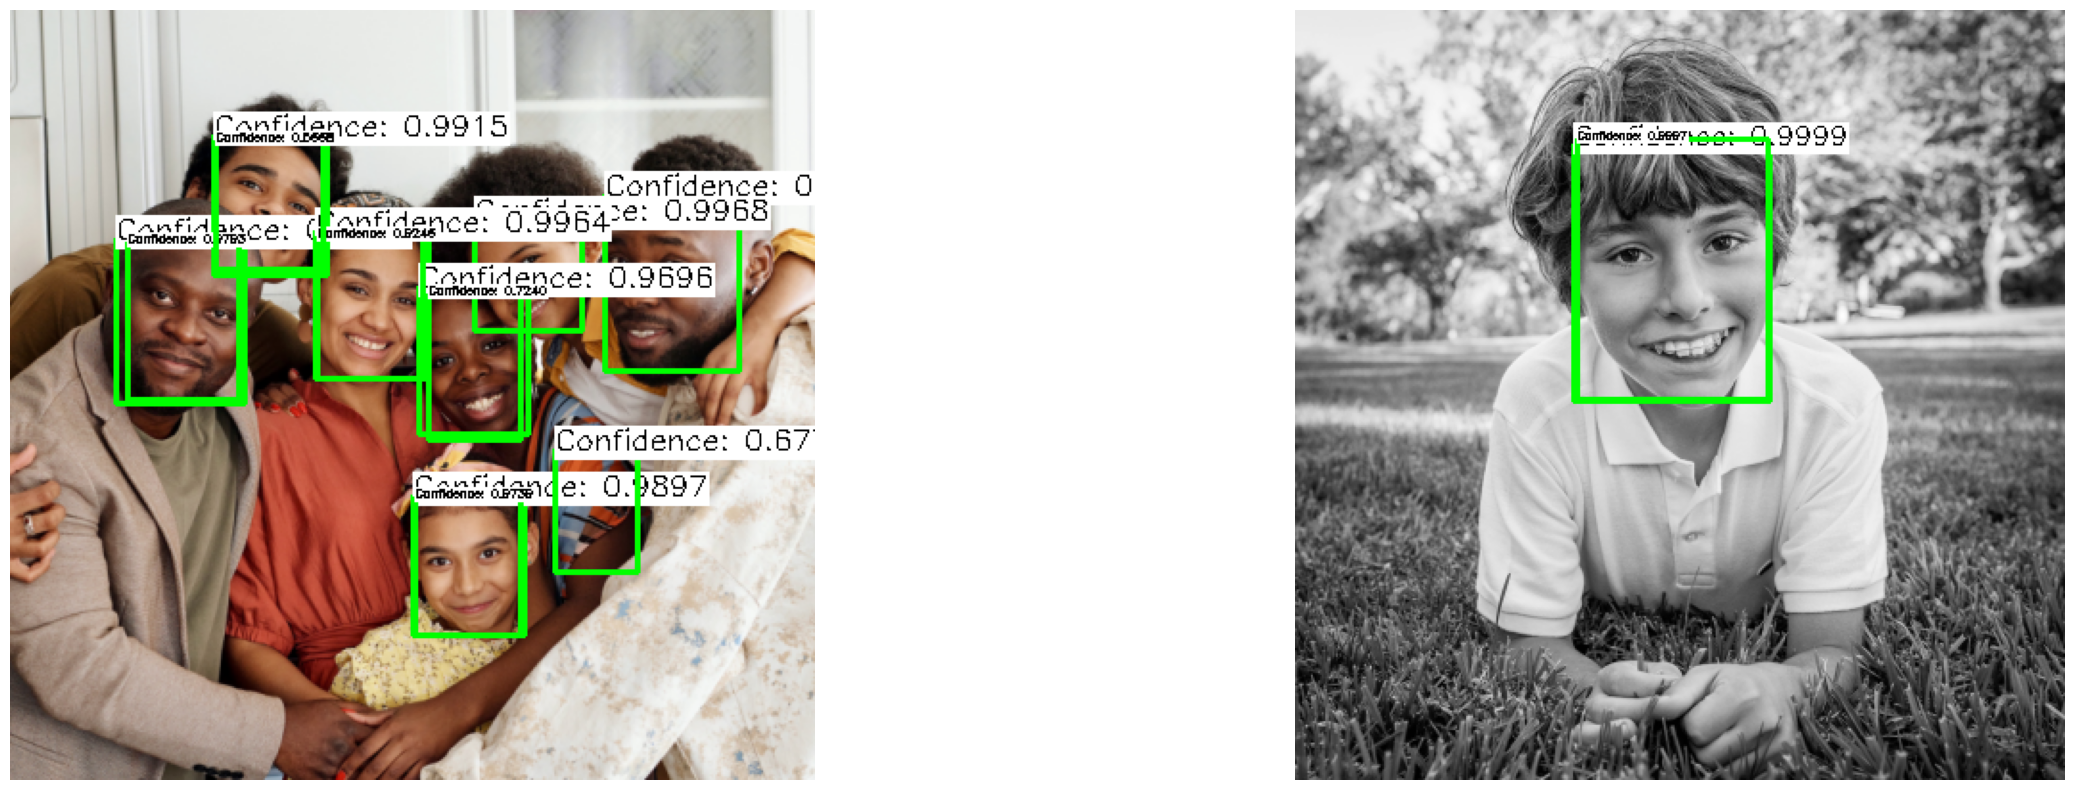

In [32]:
op1 = detect(img1)
op2 = detect(img2)

fig = plt.figure(figsize=(30,10))

plt.subplot(1,2,1); plt.axis('off'); plt.imshow(op1[:,:,::-1])
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(op2[:,:,::-1])

In [29]:
def detectAndDisplayDNN(frame):
    frame = detect(frame)
    cv2.imshow('Capture - Face detection', frame)

Ligar camera

In [30]:

cap = cv2.VideoCapture(0)

if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)

while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        cap.release()
        cv2.destroyAllWindows()
        break

    detectAndDisplayDNN(frame)

    if cv2.waitKey(10) == 27:
        cap.release()
        cv2.destroyAllWindows()
        break   

Pergntas para atividade da aula 4:
Podemos deixar de usar os dados do arquivo .xml? Qual a importância desses dados?
Não, eles são os resultados de um treinamento feito, contendo os pesos e regras obtidos nele.

É possível perceber qual implementação realiza a predição mais rapidamente?
A primeira implementação parece mais rapida em sua predição